In [72]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import math

In [157]:
def TimeWindowFunction(t, i, k, alpha):
    '''
    P_time(t=0) = P_time(t=1) = 0
    P_time(t=mu^i) = 1
    ∫_0^1 P_time(t) dt = alpha
    '''
    mu = i / (k+1)
    lamda = -math.log(2, mu) # -np.log2(2)/np.log2(mu), 换底公式
    return (16 * t**(2*lamda) * ((t**lamda-1)**2))**(alpha/mu)

In [217]:
def DistanceFunction(A, B, beta=1, gamma=1):
    '''
    two node A B
    beta := gamma to ensure the integration be 1
    smaller beta (and gamma) indicates higher probability of larger distance
    
    return probability
    '''
    distance = np.sqrt(np.sum((A-B)**2))
    return beta * np.exp(-gamma * distance)


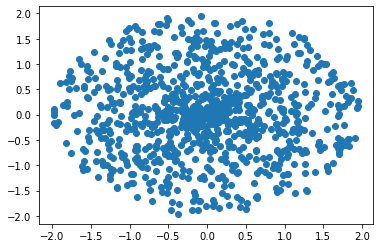

In [218]:
R = 2
y = []

for i in range(1000):
    theta = np.random.uniform(0,1)
    l = np.random.uniform(0, R)
    coordinate = [l*np.cos(2*np.pi*theta), l*np.sin(2*np.pi*theta)]
    y.append(coordinate)
y = np.array(y)
plt.scatter(y[:,0], y[:,1])

In [250]:
G = nx.Graph()
H = nx.path_graph(1000)
G.add_nodes_from(H)
for i in range(N):
    for j in range(N):
        if A[i,j] != 0:
            G.add_edge(i,j)
print('edge num: ', len(G.edges))
# delete isolated nodes from graph, otherwise omega(G) and sigma(G) error
tempgraph1 = G.copy()
if nx.is_connected(G) is False:
    G.remove_nodes_from(nx.isolates(tempgraph1))

edge num:  436


In [252]:
# sigma(G, niter=100, nrand=10, seed=None)
# niter: 每条边重新布线的近似次数，以计算等价的随机图。
# nrand: 生成的用于计算平均聚类系数(CR)和平均最短路径长度(LR)的随机图的数量。
# more details from https://www.osgeo.cn/networkx/reference/algorithms/smallworld.html

print(sigma(G)) # sigma(G)>1 for small world network
print(omega(G)) # omega(G)->0 for small world property

In [251]:
omega(G)

0.40775713758106

In [246]:
from networkx import sigma, omega

tempgraph1 = G.copy()
if not nx.is_connected(tempgraph1):
    tempgraph1.remove_nodes_from(nx.isolates(tempgraph1))
    print(omega(tempgraph1))

RuntimeError: dictionary changed size during iteration

In [225]:
p = 0.2 # ratio of inhibitory neurons
N = 100
k = 5 # number of pioneer nodes
R = 1.5 # radius of all nodes
r = 1 # radius of pioneer nodes
alpha = 0.6
theta = np.random.uniform(0,1)
pioneer_nodes = np.array([[r*np.cos(2*np.pi*(theta + i/k)), r*np.sin(2*np.pi*(theta + i/k))] for i in range(k)])

for i in range(k):
    G.add_nodes_from([
                        (i, {'xy': [pioneer_nodes[i,0], pioneer_nodes[i,1]]}),
                        ])
    # G.nodes[0]

436


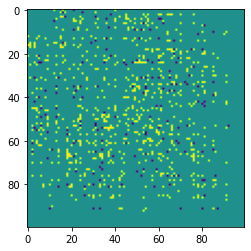

In [226]:
# STEP1: coordinates for new nodes U chosen randomly
N_coordinates = []
for _ in range(N):
    U_theta = np.random.uniform(0,1)
    l = np.random.uniform(0, R)
    coordinate = [l*np.cos(2*np.pi*U_theta), l*np.sin(2*np.pi*U_theta)]
    N_coordinates.append(coordinate)
N_coordinates = np.array(N_coordinates)

# adjacency matrix
A = np.zeros((N, N), dtype=np.float32)

# Add nodes
t = 0
sum = 0
for i in range(N):
    t += 1/N
    
    # diagonal = 0, self-connection forbidden
    A[i, i] = 0
    
    # STEP2: associated to nearest pioneer node with same time window w(U)
    xyi = N_coordinates[i, :]
    dis_pioneer = np.sqrt(np.sum((pioneer_nodes - xyi)**2, 1))
    nearest_i = np.argmin(dis_pioneer) + 1
    P_time_U = TimeWindowFunction(t, nearest_i, k, alpha)
    
    # STEP3: decide each edge with former nodes
    for j in range(0, i):
        
        xyj = N_coordinates[j, :]
        P_dist = DistanceFunction(xyi, xyj) # P distance between U and V
        
        # associated to nearest pioneer node with same time window w(V)
        dis_pioneer = np.sqrt(np.sum((pioneer_nodes - xyj)**2, 1))
        nearest_j = np.argmin(dis_pioneer) + 1
        P_time_V = TimeWindowFunction(t, nearest_j, k, alpha)
        
        if np.random.rand() < P_dist * P_time_U * P_time_V:
            sum += 1
            if np.random.rand() < p: A[i, j] = -1   # inhibitory connection
            else: A[i, j] = 1                       # excitatory connection
            
            if np.random.rand() < p: A[j, i] = -1
            else: A[j, i] = 1
        
        
        
        
        # print((j, i), (i, j))
print(sum)
plt.imshow(A)

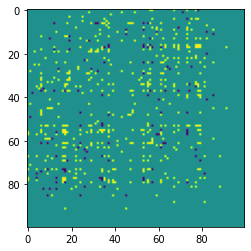

In [ ]:
t = 0
max = 0
for i in range(N):
    t += 1/N
    
    # coordinates for a new node U chosen randomly
    U_theta = np.random.uniform(0,1)
    l = np.random.uniform(0, R)
    coordinate = np.array([l*np.cos(2*np.pi*theta), l*np.sin(2*np.pi*theta)])
    
    # associated to the nearest pioneer node with same time window w(U)
    dis_pioneer = np.sqrt(np.sum((pioneer_nodes - coordinate)**2, 1))
    nearest_idx = np.argmin(dis_pioneer) + 1
    P_time_U = TimeWindowFunction(t, nearest_idx, k, 0.3)
    for node
    
print(max)

In [128]:
A = np.random.rand(2)
B = np.random.rand(2)
DistanceFunction(A, B, beta=3, gamma=3)


2.0783077828812817

In [130]:
A,B

(array([0.48084942, 0.5345    ]), array([0.36431718, 0.57178857]))

In [136]:
6*np.exp(-6*np.sqrt(0.11653224**2 + 0.03728857**2))

2.8795753839061065

In [81]:
D = np.arange(0,100,0.001)
sum = 0
for d in D:
    sum += DistanceFunction(1,2,d,3,3)*.001
print(sum)

1.001500749999859


In [58]:
pioneer_nodes

array([[-1.07399894, -4.88329052],
       [ 4.31240134, -2.53045345],
       [ 3.73920954,  3.31938428],
       [-2.00144275,  4.58194575],
       [-4.97616919, -0.48758607]])

In [98]:
TimeWindowFunction(1/6, 1, 5, 0.03)

1.0

In [96]:
dt = 1e-3
T = np.arange(0, 1+dt, dt)
sum = 0
for t in T:
    sum += TimeWindowFunction(t, 1, 5, 1.2) * dt
print(sum)

0.1990470003811299


In [61]:
i/(6)

NameError: name 'i' is not defined

In [78]:
import math
math.log(3, 2)
# np.log2(3)

1.5849625007211563

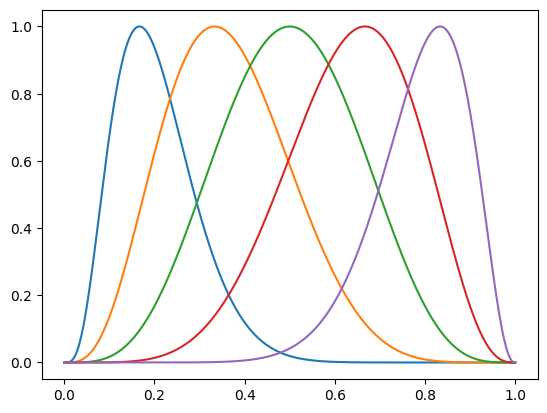

In [84]:
def TimeWindowFunction(t, i, k, alpha):
    # 改成gamma分布
    mu = i / (k+1)
    lamda = -math.log(2, mu) # -np.log2(2)/np.log2(mu), 换底公式
    return (16 * t**(2*lamda) * ((t**lamda-1)**2))**(alpha/mu)

T = np.arange(0, 1.001, 0.001)
y = []
for t in T:
    y.append([TimeWindowFunction(t, j, 5, 1) for j in range(1,6)])
y = np.array(y)
plt.plot(T, y[:,0])
plt.plot(T, y[:,1])
plt.plot(T, y[:,2])
plt.plot(T, y[:,3])
plt.plot(T, y[:,4])

In [44]:
1/np.max(y[:,3])

256.0003742040128

In [49]:
for i in range(k,100):
    print(i)

5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [1]:
from train import *
import matplotlib.pyplot as plt
from utils import *

In [5]:
config = {
    'alpha':0.5,
    'decay':0.5,
    'thr': 1.2,
    'R': 0.05,
    'p': 0.25,
    'gamma': 1.0,
}
model = config_model(config)
# print(1000**2-(model.A==0).sum())
# print(spectral_radius(model.A))
rollout(config)

0.15333333333333332 0.115


{'objs': (-0.115,)}

In [6]:
model.N_hid

1000

In [4]:
# np.max(model.A)
rollout(config)

0.15 0.125


{'objs': (-0.125,)}

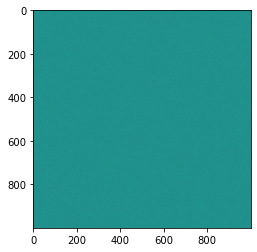

In [6]:
plt.imshow(model.A)
plt.show()


In [ ]:
train_loader, test_loader = MNIST_generation(train_num=100,
                                             test_num=250,
                                             batch_size=13)

inference(model, train_loader, frames=20)

t = time.time()
rollout(config)
print(time.time()-t)

1.0000000000000016


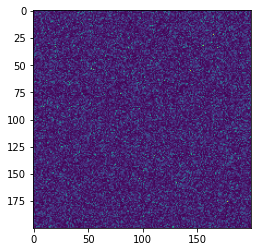

In [34]:
gamma_list = [np.random.gamma(1.0) for _ in range(40000)]
gamma_m = np.array(gamma_list).reshape(200,200)
gamma_m /= spectral_radius(gamma_m)
print(spectral_radius(gamma_m))
plt.imshow(gamma_m)
# plt.hist(gamma_list,bins=100)